In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, 1:].values
        self.X = self.X.reshape(-1,1, 28, 28).astype(np.float32)/255
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [4]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x= self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

        
        

In [7]:
def model_training(model, optimizer, criterion, epochs=50):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [],[]

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train = 0
        correct_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            value, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted==labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss/len(train_loader)
        train_accuracy = correct_train/total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct_test+=(predicted==labels).sum().item()
                total_test +=labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
    
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%")

                
    return train_losses, test_losses, train_accuracies, test_accuracies
        

In [8]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [9]:
train_losses_ce, test_losses_ce, train_acc_ce, test_acc_ce = model_training(model, optimizer, criterion)

Epoch 1/50 | Train Loss: 0.4226, Train Acc: 92.24% | Test Loss: 0.1416, Test Acc: 96.81%
Epoch 2/50 | Train Loss: 0.0974, Train Acc: 97.65% | Test Loss: 0.0791, Test Acc: 97.91%
Epoch 3/50 | Train Loss: 0.0597, Train Acc: 98.49% | Test Loss: 0.0574, Test Acc: 98.32%
Epoch 4/50 | Train Loss: 0.0432, Train Acc: 98.86% | Test Loss: 0.0455, Test Acc: 98.53%
Epoch 5/50 | Train Loss: 0.0335, Train Acc: 99.14% | Test Loss: 0.0382, Test Acc: 98.67%
Epoch 6/50 | Train Loss: 0.0281, Train Acc: 99.29% | Test Loss: 0.0343, Test Acc: 98.90%
Epoch 7/50 | Train Loss: 0.0237, Train Acc: 99.39% | Test Loss: 0.0308, Test Acc: 98.98%
Epoch 8/50 | Train Loss: 0.0205, Train Acc: 99.48% | Test Loss: 0.0290, Test Acc: 99.06%
Epoch 9/50 | Train Loss: 0.0179, Train Acc: 99.54% | Test Loss: 0.0288, Test Acc: 98.98%
Epoch 10/50 | Train Loss: 0.0163, Train Acc: 99.59% | Test Loss: 0.0260, Test Acc: 99.06%
Epoch 11/50 | Train Loss: 0.0147, Train Acc: 99.61% | Test Loss: 0.0260, Test Acc: 99.10%
Epoch 12/50 | Train

In [10]:
def model_training_MSE(model, optimizer, criterion, epochs=50):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [],[]

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train = 0
        correct_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            labels_one_hot = F.one_hot(labels, num_classes=5).float()
            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            value, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted==labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss/len(train_loader)
        train_accuracy = correct_train/total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                labels_one_hot = F.one_hot(labels, num_classes=5).float()
                loss = criterion(outputs, labels_one_hot)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct_test+=(predicted==labels).sum().item()
                total_test +=labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
    
        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%")

                
    return train_losses, test_losses, train_accuracies, test_accuracies
        

In [11]:
model2 = CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.00001)

In [12]:
train_losses_mse, test_losses_mse, train_acc_mse, test_acc_mse = model_training_MSE(model2, optimizer, criterion)

Epoch 1/50 | Train Loss: 0.0422, Train Acc: 92.55% | Test Loss: 0.0218, Test Acc: 98.04%
Epoch 2/50 | Train Loss: 0.0182, Train Acc: 98.54% | Test Loss: 0.0157, Test Acc: 98.59%
Epoch 3/50 | Train Loss: 0.0136, Train Acc: 99.01% | Test Loss: 0.0125, Test Acc: 98.79%
Epoch 4/50 | Train Loss: 0.0111, Train Acc: 99.24% | Test Loss: 0.0108, Test Acc: 98.94%
Epoch 5/50 | Train Loss: 0.0095, Train Acc: 99.33% | Test Loss: 0.0096, Test Acc: 99.04%
Epoch 6/50 | Train Loss: 0.0083, Train Acc: 99.43% | Test Loss: 0.0090, Test Acc: 99.12%
Epoch 7/50 | Train Loss: 0.0075, Train Acc: 99.50% | Test Loss: 0.0079, Test Acc: 99.20%
Epoch 8/50 | Train Loss: 0.0068, Train Acc: 99.54% | Test Loss: 0.0074, Test Acc: 99.20%
Epoch 9/50 | Train Loss: 0.0062, Train Acc: 99.57% | Test Loss: 0.0070, Test Acc: 99.20%
Epoch 10/50 | Train Loss: 0.0057, Train Acc: 99.61% | Test Loss: 0.0067, Test Acc: 99.28%
Epoch 11/50 | Train Loss: 0.0054, Train Acc: 99.64% | Test Loss: 0.0063, Test Acc: 99.30%
Epoch 12/50 | Train

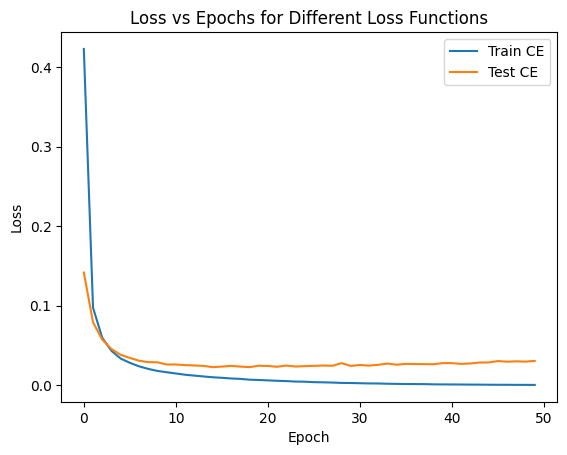

In [13]:
plt.plot(train_losses_ce, label='Train CE')
plt.plot(test_losses_ce, label='Test CE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Different Loss Functions")
plt.legend()
plt.show()

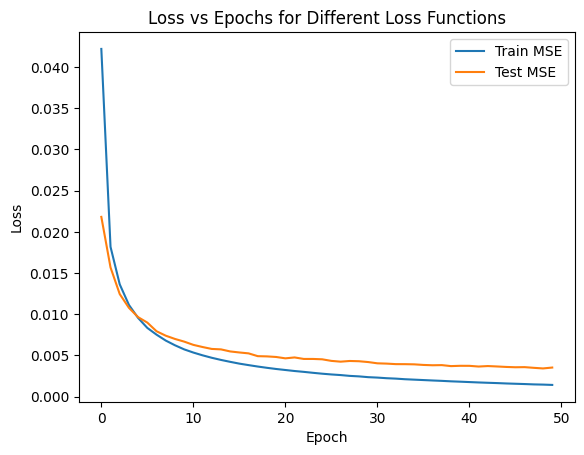

In [14]:
plt.plot(train_losses_mse, label='Train MSE')
plt.plot(test_losses_mse, label='Test MSE')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for Different Loss Functions")
plt.legend()
plt.show()

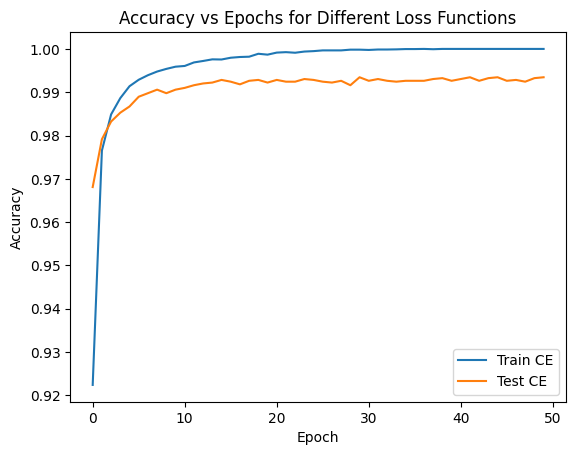

In [15]:
plt.plot(train_acc_ce, label='Train CE')
plt.plot(test_acc_ce, label='Test CE')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs for Different Loss Functions")
plt.legend()
plt.show()


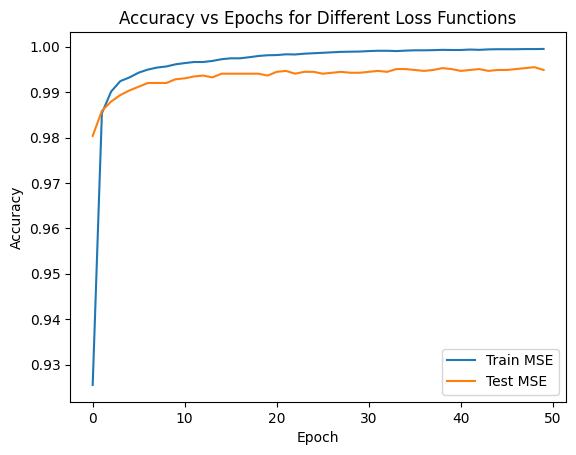

In [16]:
plt.plot(train_acc_mse, label='Train MSE')
plt.plot(test_acc_mse, label='Test MSE')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs for Different Loss Functions")
plt.legend()
plt.show()
